In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from pykalman import KalmanFilter
from utils import find_cointegrated_pairs, trading, plot_trading_result

In [2]:
# load time series
AUD = pd.read_csv("../data/AUD.csv")
EUR = pd.read_csv("../data/EUR.csv")
GBP = pd.read_csv("../data/GBP.csv")
NZD = pd.read_csv("../data/NZD.csv")

df = AUD.merge(EUR,on='Date').merge(GBP,on='Date').merge(NZD,on='Date')
df.columns = ["Date", "AUD", "EUR", "GBP", "NZD"]

In [3]:
prices_df = df[["AUD", "EUR", "GBP", "NZD"]]

prices_df = prices_df.iloc[6192:,].reset_index(drop=True) # from 2009-01-01

# Pairs selection & Cointegration test

In [4]:
pvalues, pairs = find_cointegrated_pairs(prices_df) 

In [5]:
stock_list = ["AUD", "EUR", "GBP", "NZD"]

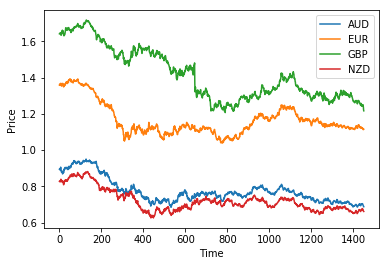

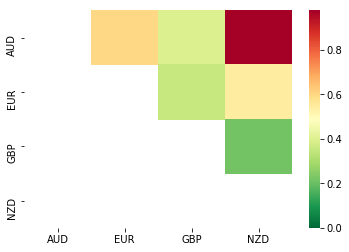

In [6]:
plt.plot(prices_df["AUD"])
plt.plot(prices_df["EUR"])
plt.plot(prices_df["GBP"])
plt.plot(prices_df["NZD"])
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend(stock_list,loc='best')
plt.show()

sns.heatmap(1-pvalues, xticklabels=stock_list, yticklabels=stock_list, cmap='RdYlGn_r', mask = (pvalues == 1))
plt.show()

In [7]:
stock_df1 = prices_df["AUD"]
stock_df2 = prices_df["NZD"]

In [8]:
val_num = int(len(stock_df1)*0.2)
print("validation range: {} dates".format(val_num))

validation range: 290 dates


In [9]:
X = np.array(stock_df1[:-val_num]).reshape(-1,1)
y = np.array(stock_df2[:-val_num])
reg = LinearRegression().fit(X, y)
gamma = reg.coef_
u = reg.intercept_
print("r square:", reg.score(X, y))
print("gamma:{}".format(gamma))
print("mu:{}".format(u))

r square: 0.9236237635516851
gamma:[0.87728278]
mu:0.04033477686760911


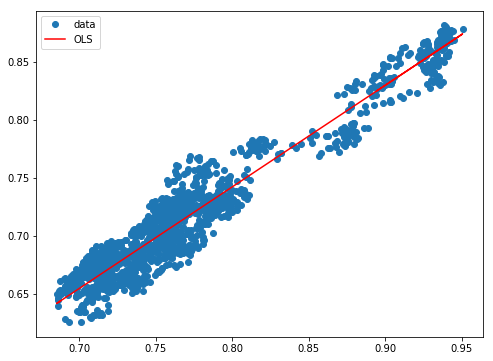

In [10]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(stock_df1, stock_df2,'o', label="data")
ax.plot(stock_df1, stock_df1*gamma+u, 'r', label="OLS")
ax.legend(loc='best')
plt.show()

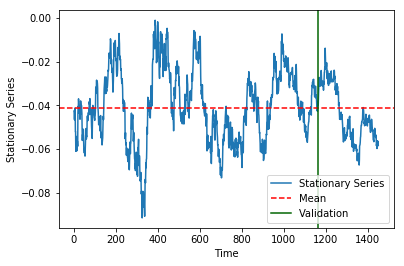

In [11]:
plt.plot(gamma*stock_df1-stock_df2);
plt.axhline((gamma*stock_df1-stock_df2).mean(), color="red", linestyle="--")
plt.axvline(x=len(stock_df1)-val_num,color="darkgreen")
plt.xlabel("Time"); plt.ylabel("Stationary Series")
plt.legend(["Stationary Series", "Mean","Validation"], loc="best")
plt.show()

In [12]:
val_num

290

# tests for the stationarity of $\hat{\epsilon_t}$ (Augmented Dickey-Fuller test)

In [13]:
e = stock_df2 - stock_df1*gamma+u

In [14]:
result = adfuller(e)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.750418
p-value: 0.003457
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


# Trading strategy design - baseline

In [15]:
z = stock_df2 - stock_df1*gamma

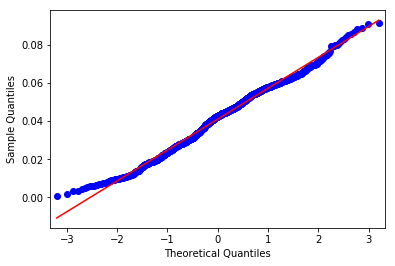

In [16]:
# spread normal dist.?
qqplot(z, line='s')
plt.show()

### z-score method (standard normalizatoin)

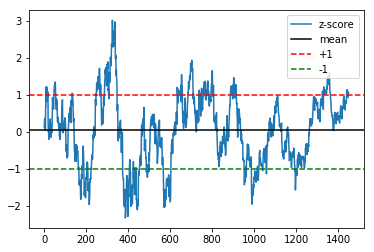

In [17]:
# z normalization using train mean and std
train_mean = np.mean(z[:-val_num])
train_std = np.std(z[:-val_num])
z_zscore = (z-train_mean)/train_std

plt.plot(z_zscore)
plt.axhline(z_zscore.mean(), color="black")
plt.axhline(1.0, color="red", linestyle="--")
plt.axhline(-1.0, color="green", linestyle="--")
plt.legend(["z-score", "mean", "+1", "-1"])
plt.show()

Total profit = profit of each trade × number of trades
* profit of each trade is $s_0$
* number of trades is related to the zero crossings, which can be analyzed theoretically as well as empirically.

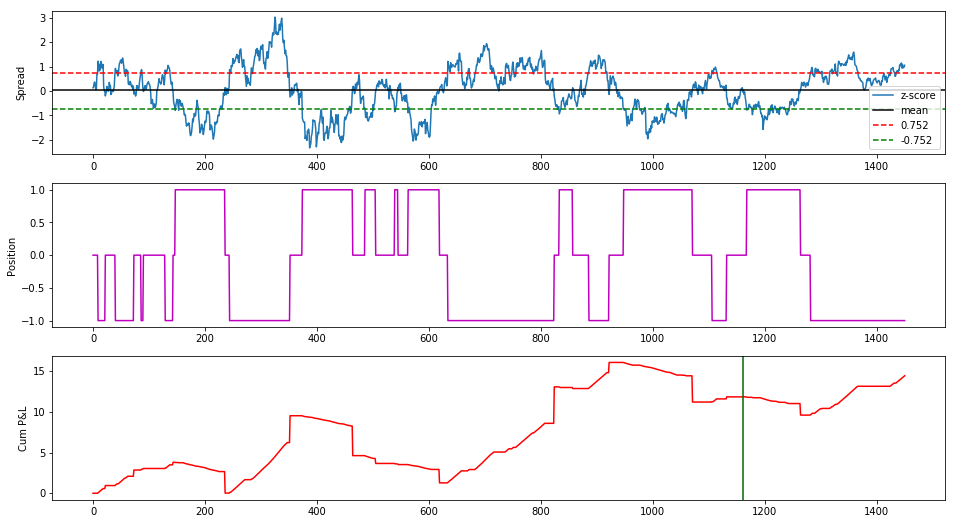

cumulative profit: 14.437813339219806
validation cumulative profit: 2.593403468491603


In [18]:
S = np.arange(0.0, 3.0, 0.001)
prob = 1-norm.cdf(S, scale=1)
total_profit = S*(len(prices_df["EUR"])-val_num)*(1-norm.cdf(S)) # use standard normal
s0 = S[np.argmax(total_profit)]
# s0 = 1
spread = -stock_df2 + stock_df1*gamma

position, profit, cum_profit = trading(z_zscore, s0, spread)
plot_trading_result(z_zscore, position, profit, s0, val_num)

print("cumulative profit:", cum_profit)
print("validation cumulative profit:",profit[-1]-profit[-val_num])

The problem with the LS regression is that it assumes that $\mu$ and $\gamma$ are constant.

### Optimum threshold $s_0$: Parametric approach

In [19]:
# the number of tradable events = T*(1-phi(s0))
# total profit = s0*T*(1-phi(s0))

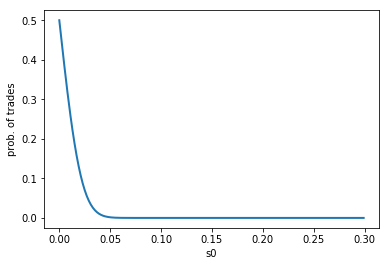

In [20]:
dist = GaussianMixture()
dist.fit(np.array(z[:-val_num]).reshape(-1,1))
S = np.arange(0.0, 0.3, 0.001)
prob = 1-norm.cdf(S, scale=dist.covariances_[0][0][0]**0.5)
line, = plt.plot(S, prob, lw=2)
plt.ylabel("prob. of trades")
plt.xlabel("s0")
plt.show()

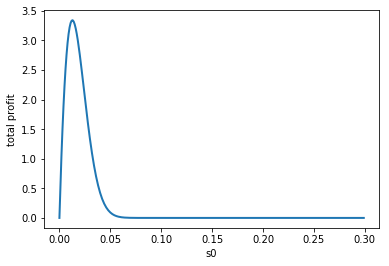

In [21]:
total_profit = S*(len(prices_df["EUR"])-val_num)*(prob)
line, = plt.plot(S, total_profit, lw=2)
plt.xlabel("s0")
plt.ylabel("total profit")
plt.show()

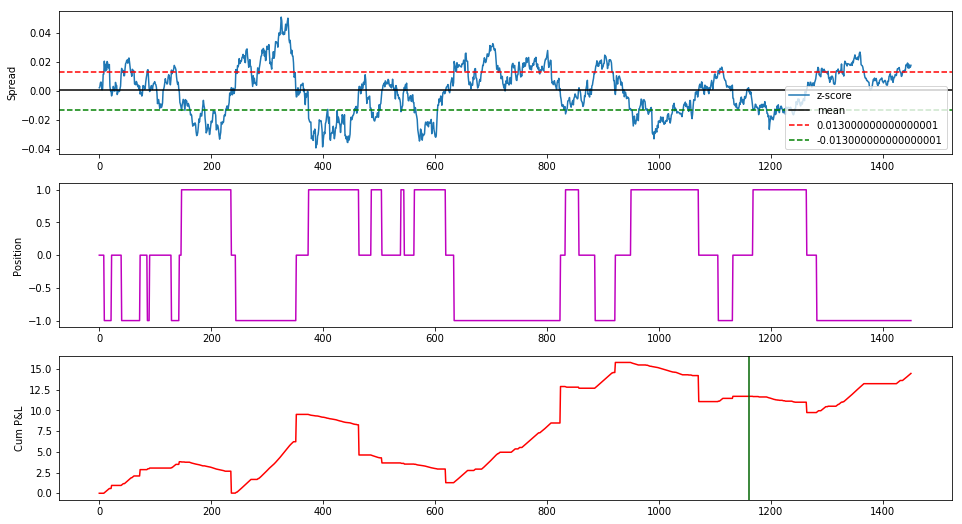

cumulative profit: 14.475909479925237


In [22]:
dist = GaussianMixture()
dist.fit(np.array(z[:-val_num]).reshape(-1,1))
S = np.arange(0.0, 3., 0.001)
prob = 1-norm.cdf(S, scale=dist.covariances_[0][0][0]**0.5)
total_profit = S*(len(prices_df["EUR"])-val_num)*(prob)
s0 = S[np.argmax(total_profit)]

spread = -stock_df2 + stock_df1*gamma
z_zero_mean = z-u

position, profit, cum_profit = trading(z_zero_mean, s0, spread)

plot_trading_result(z_zero_mean, position, profit, s0, val_num)

print("cumulative profit:", cum_profit)

# Kalman for pairs trading

In [23]:
transition_matrices = [[1, 0], [0, 1]]
observation_matrices = np.expand_dims(np.vstack([[stock_df1], [np.ones(len(stock_df1))]]).T, axis=1)
np.random.seed(0)
kf = KalmanFilter(transition_matrices = transition_matrices, observation_matrices = observation_matrices[:-val_num])
kf.em(stock_df2[:-val_num])
filter_mean,filter_cov = kf.filter(stock_df2[:-val_num])

In [24]:
for i in range(len(stock_df1)-val_num, len(stock_df1)):
    observation_matrix = observation_matrices[i]
    observation = stock_df2[i]
    
    next_filter_mean,next_filter_cov = kf.filter_update(
            filtered_state_mean = filter_mean[-1],
            filtered_state_covariance = filter_cov[-1],
            observation = observation,
            observation_matrix = observation_matrix)

    filter_mean = np.vstack((filter_mean,next_filter_mean))
    filter_cov = np.vstack((filter_cov,next_filter_cov.reshape(1,2,2)))

In [25]:
kf_gammas = filter_mean[:,0]
kf_us = filter_mean[:,1]

In [26]:
z = stock_df2 - stock_df1*kf_gammas

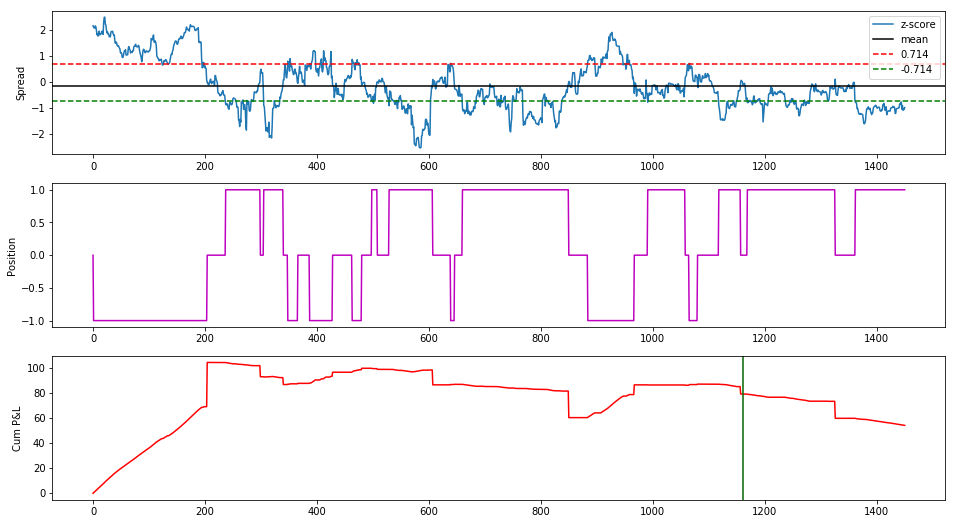

cumulative profit: 54.099908241772745
validation cumulative profit: -24.944035911881706


In [27]:
train_mean = np.mean(z[:-val_num])
train_std = np.std(z[:-val_num])
z_zscore_kf = (z-train_mean)/train_std

S = np.arange(0.0, 3.0, 0.001)
prob = 1-norm.cdf(S, scale=z_zscore_kf.std())
total_profit = S*(len(prices_df["EUR"])-val_num)*(prob) # use standard normal
s0 = S[np.argmax(total_profit)]


spread = -stock_df2 + stock_df1*kf_gammas

position, profit, cum_profit = trading(z_zscore_kf, s0, spread)

plot_trading_result(z_zscore_kf, position, profit, s0, val_num)

print("cumulative profit:", cum_profit)
print("validation cumulative profit:",profit[-1]-profit[-val_num])